In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import os
from dotenv import load_dotenv

load_dotenv()

True

load

In [9]:
ROOT_PROJ_PATH = os.getenv("ABS_PROJ_PATH")
abs_rootpath = ROOT_PROJ_PATH + "examples/election/output/"
print(abs_rootpath)

/mnt/c/Users/maxpu/Dropbox/scripts/Projects/socialsandbox/mastodon-sim/examples/election/output/


In [12]:
# in output_proc_utils.py

import collections


def load_data(fileroot):
    with open(fileroot + ".json") as file:
        config_data = json.load(file)
    df = pd.read_json(fileroot + "_output.jsonl", lines=True)

    pd.set_option("display.width", 1000)
    print(df.head())
    print()
    print("Evals:")
    print(df.loc[df.event_type == "eval", "label"].value_counts())
    print()
    print("Actions:")
    print(df.loc[(df.event_type == "action") & (df.episode > -1), "label"].value_counts())
    print()
    print(
        df.loc[(df.event_type == "action") & (df.episode > -1), "data"]
        .apply(lambda x: x.keys())
        .value_counts()
    )
    print()
    names_of_focalplayers = ["Bill Fredrickson", "Bradley Carter", "Glenn Patterson"]
    print(
        df.loc[
            (df.source_user.isin(names_of_focalplayers))
            & (df.event_type == "action")
            & (df.episode > -1)
        ]
        .groupby("source_user")["label"]
        .value_counts()
    )
    print()
    print("post")
    posts = df.loc[
        (df.label == "post") & (df.episode > -1) & (df.source_user != "storhampton_gazette"),
        ["source_user", "data"],
    ]
    users = posts["source_user"].values
    posts = posts["data"].apply(lambda x: x["post_text"]).values
    for user, post in zip(users, posts):
        print(f"source_user:{user}:{post}")
    print()
    print("reply")
    replies = df.loc[
        (df.label == "reply") & (df.episode > -1) & (df.source_user != "storhampton_gazette"),
        ["source_user", "episode", "data"],
    ]
    users = replies["source_user"].values
    replies = replies["data"].apply(lambda x: x["post_text"]).values
    for user, reply in zip(users, replies):
        print(f"source_user:{user}:{reply}")
    print()
    dftmp = df.copy()
    dftmp = dftmp.loc[(dftmp.event_type == "action") & (dftmp.episode > -1), :]
    dftmp["data"] = dftmp["data"].apply(str)
    print(f"{(len(dftmp) - len(dftmp.drop_duplicates())) / len(dftmp):.3f} duplicate fraction")
    return df


def post_process_output(df):
    eval_df = df.loc[
        df.event_type == "eval", ["episode", "source_user", "label", "data"]
    ].reset_index(drop=True)
    eval_df["response"] = eval_df.data.apply(lambda x: x["query_return"])
    eval_df = eval_df.drop("data", axis=1)

    edge_df = df.loc[
        df.label.isin(["follow", "unfollow"]), ["episode", "source_user", "data", "label"]
    ].reset_index(drop=True)
    edge_df["target_user"] = edge_df.data.apply(lambda d: d["target_user"])
    edge_df = edge_df.drop("data", axis=1)

    interaction_types = ["post", "like_toot", "boost_toot", "reply"]
    int_df = df.loc[df.label.isin(interaction_types), :].reset_index(drop=True)
    return eval_df, int_df, edge_df


def episodewise_graphbuild(edge_df):
    follow_graph = nx.DiGraph()
    for epi_edge_data in edge_df.groupby("episode"):
        for action, operate_on_graph in zip(
            ["follow", "unfollow"], [follow_graph.add_edges_from, follow_graph.remove_edges_from]
        ):
            if (epi_edge_data.label == action).any():
                data = epi_edge_data.loc[
                    epi_edge_data.label == action, ["source_user", "target_user"]
                ]
                operate_on_graph(list(data.itertuples(index=False, name=None)))
    return follow_graph


# in dashboard-basic.py:


def get_target_user(row):
    if row.label == "post":
        target_user = row.source_user
    elif row.label == "like_toot":
        target_user = row.data["target_user"]
    elif row.label == "boost_toot":
        target_user = row.data["target_user"]
    elif row.label == "reply":
        target_user = row.data["reply_to"]["target_user"]
    return target_user


def get_int_dict(int_df):
    past = dict(
        zip(["post", "like_toot", "boost_toot", "reply"], ["posted", "liked", "boosted", "replied"])
    )
    int_df["int_data"] = int_df.apply(
        lambda x: {
            "action": past[x.label],
            "episode": x.episode,
            "source_user": x.source_user,
            "target_user": get_target_user(x),
            "toot_id": x.data["toot_id"],
        },
        axis=1,
    )
    int_df.int_data = int_df.apply(
        lambda x: x.int_data | {"parent_toot_id": x.data["reply_to"]["toot_id"]}
        if x.label == "reply"
        else x.int_data,
        axis=1,
    )
    return int_df.groupby("episode")["int_data"].apply(list).to_dict()


def get_toot_dict(int_df):
    past = dict(
        zip(["post", "like_toot", "boost_toot", "reply"], ["posted", "liked", "boosted", "replied"])
    )
    text_df = int_df.loc[(int_df.label == "post") | (int_df.label == "reply"), :].reset_index(
        drop=True
    )

    # handle Nones as toot_ids by appending an index
    no_toot_id = text_df.data.apply(lambda x: x["toot_id"] is None)
    text_df["no_toot_id_idx"] = -1
    text_df.loc[no_toot_id, "no_toot_id_idx"] = range(no_toot_id.sum())
    text_df.loc[no_toot_id, "data"] = text_df.loc[no_toot_id, :].apply(
        lambda x: x.data | {"toot_id": "None" + str(x.no_toot_id_idx)}, axis=1
    )

    text_df["toot_id"] = text_df.data.apply(lambda x: x["toot_id"])
    text_df = text_df.set_index("toot_id")
    text_df["text_data"] = text_df.apply(
        lambda x: {"user": x.source_user, "action": past[x.label], "content": x.data["post_text"]},
        axis=1,
    )
    text_df.text_data = text_df.apply(
        lambda x: x.text_data | {"parent_toot_id": x.data["reply_to"]["toot_id"]}
        if x.label == "reply"
        else x.text_data,
        axis=1,
    )

    return text_df.text_data.to_dict()


def load_data_dash(eval_df, int_df, edge_df):
    # votes
    votes = (
        eval_df.loc[eval_df.label == "vote_pref", ["source_user", "response", "episode"]]
        .groupby("episode")
        .apply(lambda x: dict(zip(x.source_user, x.response)))
        .to_dict()
    )

    # final follow network
    follow_graph = nx.from_pandas_edgelist(
        edge_df, "source_user", "target_user", create_using=nx.DiGraph()
    )  # invalid in presence of unfollows (in which case use episodewise_graphbuild)

    # active users with episode keys
    posted_users_by_episode = int_df.groupby("episode")["source_user"].apply(set).to_dict()

    # interaction data
    int_dict = get_int_dict(int_df.copy())

    # toot_data
    toot_dict = get_toot_dict(int_df.copy())

    return follow_graph, int_dict, posted_users_by_episode, toot_dict, votes

In [13]:
print(fileroot)

/mnt/c/Users/maxpu/Dropbox/scripts/Projects/socialsandbox/mastodon-sim/examples/election/output/N20_T6_Reddit_Big5_independent_v1_news_no_bias_with_images_v14refactor


In [14]:
# fileroot=abs_rootpath+'N20_T48_None_Big5_independent'
# fileroot=abs_rootpath+'N20_T48_None_Big5_malicious'
# fileroot=abs_rootpath+'call2action_v1_N20_T48_None_Big5_independent'
# fileroot=abs_rootpath+'call2action_v1_N20_T48_None_Big5_malicious'
# fileroot=abs_rootpath+'call2action_v4e_N20_T48_None_Big5_independent'
# fileroot=abs_rootpath+'call2action_v4g_N20_T48_None_Big5_independent'
fileroot = abs_rootpath + "testnewcode_v1_news_no_bias_N20_T1_Reddit_Big5_independent"
# fileroot=abs_rootpath+'testnewcodepost07sugact_v1_news_no_bias_N20_T12_Reddit_Big5_independent'
fileroot = (
    abs_rootpath
    + "testnewcodepost07sugactnewcall2act_v1_news_no_bias_N20_T12_Reddit_Big5_independent"
)
# fileroot=abs_rootpath+'N20_T12_Reddit_Big5_independent_v1_news_bill_bias_with_images'
# fileroot=abs_rootpath+'N20_T6_Reddit_Big5_independent_v1_news_no_bias_with_images_v1_newc2a'
# fileroot=abs_rootpath+'N20_T6_Reddit_Big5_independent_v1_news_no_bias_with_images_v3maincall2act'
# fileroot=abs_rootpath+'N20_T3_Reddit_Big5_independent_v1_news_no_bias_with_images_v7activerates'
fileroot = abs_rootpath + "N20_T3_Reddit_Big5_independent_v1_news_no_bias_with_images_v8betterc2a"
fileroot = abs_rootpath + "N20_T12_Reddit_Big5_independent_v1_news_no_bias_with_images_v11nosurveys"
fileroot = (
    abs_rootpath + "N20_T12_Reddit_Big5_independent_v1_news_no_bias_with_images_v12addconduct"
)
fileroot = abs_rootpath + "N20_T12_Reddit_Big5_malicious_v1_news_bill_bias_with_images_v13refactor"
fileroot = (
    abs_rootpath + "N20_T6_Reddit_Big5_independent_v1_news_bradley_bias_with_images_v13refactor"
)
fileroot = (
    abs_rootpath + "N20_T24_Reddit_Big5_independent_v1_news_no_bias_with_images_v13refactor"
)
fileroot = (
    abs_rootpath + "N20_T6_Reddit_Big5_independent_v1_news_no_bias_with_images_v14refactor"
)
df = load_data(fileroot)

     source_user   label                                               data  episode event_type
0  Sam Robertson  follow  {'target_user': 'Zachary Patel', 'suggested_ac...       -1     action
1   Lisa Collins  follow  {'target_user': 'Laura Mitchell', 'suggested_a...       -1     action
2  Carlos Mendes  follow  {'target_user': 'Michael Robertson', 'suggeste...       -1     action
3    Rahul Desai  follow  {'target_user': 'Bradley Carter', 'suggested_a...       -1     action
4     Emily Chen  follow  {'target_user': 'Bradley Carter', 'suggested_a...       -1     action

Evals:
label
favorability    240
vote_pref       120
vote_intent     120
Name: count, dtype: int64

Actions:
label
boost_toot          31
like_toot           30
post                27
reply               11
get_own_timeline     5
Name: count, dtype: int64

data
(toot_id, target_user, suggested_action)            61
(toot_id, post_text, suggested_action)              27
(reply_to, toot_id, post_text, suggested_action)   

In [7]:
# fn="examples/election/output/N20_T24_Reddit_Big5_independent_v1_news_no_bias_with_images_v13refactor.jsonprompts_and_responses.jsonl"
fn="examples/election/output/N20_T6_Reddit_Big5_independent_v1_news_no_bias_with_images_v13refactor.jsonprompts_and_responses.jsonl"

df=pd.read_json(fn,lines=True)

In [4]:
filtered_df=df.loc[df.prompt.str.contains("Creative Writing" ),:]
filtered_df.head()

,prompt,output,episode_idx,player_name
0,----- Creative Writing Master Class -----\n\nQ...,Emily Chen was born in 1984 in the quaint town...,-1,not found
1,----- Creative Writing Master Class -----\n\nQ...,Rachel Kim was born in 1984 in the quaint town...,-1,not found
2,----- Creative Writing Master Class -----\n\nQ...,Sam Jenkins was born in 1984 in the quaint tow...,-1,not found
3,----- Creative Writing Master Class -----\n\nQ...,Alex Thompson was born in 1984 in the quaint t...,-1,not found
4,----- Creative Writing Master Class -----\n\nQ...,Michael Robertson was born in 1984 in the smal...,-1,not found


In [6]:
agent_name = 'Michael Robertson'
# agent_name = 'Bill Fredrickson'
filtered_df=df.loc[df.prompt.str.contains(
    "Here is a list of the kinds of actions to select from, and what they accomplish:"
    ) & (df.episode_idx==4) & (df.player_name==agent_name),:]
filtered_df

,prompt,output,episode_idx,player_name
12062,Role playing instructions: The instructions fo...,decides to follow a new account on the Storham...,4,Michael Robertson
12292,Role playing instructions: The instructions fo...,decides to boost a post that resonates with hi...,4,Michael Robertson
12379,Role playing instructions: The instructions fo...,decides to reply to a post that resonates with...,4,Michael Robertson
12424,Role playing instructions: The instructions fo...,"decides to reply to Lisa's post, as it resonat...",4,Michael Robertson
12536,Role playing instructions: The instructions fo...,decides to like the post from Laura (@user0006...,4,Michael Robertson
12591,Role playing instructions: The instructions fo...,decides to reply to a post that resonates with...,4,Michael Robertson
12646,Role playing instructions: The instructions fo...,decides to reply to a post that resonates with...,4,Michael Robertson
12712,Role playing instructions: The instructions fo...,"decides to reply to Sam's post, as it resonate...",4,Michael Robertson
12771,Role playing instructions: The instructions fo...,decides to reply to a post that resonates with...,4,Michael Robertson
12839,Role playing instructions: The instructions fo...,decides to reply to a post that resonates with...,4,Michael Robertson


ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

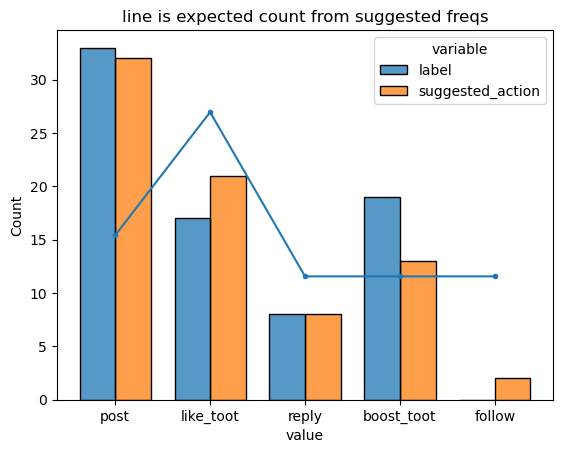

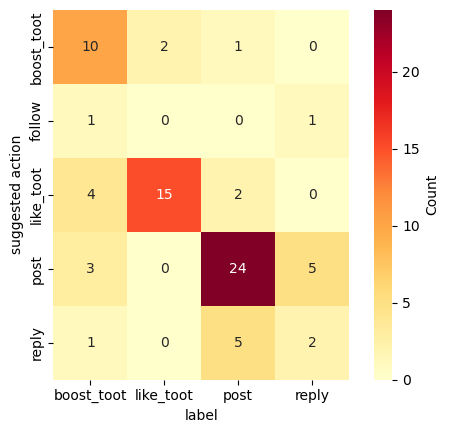

In [ ]:
import seaborn as sns
import matplotlib.pyplot as pl

action_probabilities = {
    "like_toot": 0.05,  # 20,  # Most common action
    "boost_toot": 0.05,  # 0.15,  # Common but less than likes
    "post": 0.7,  # 0.35,  # Regular posting
    "reply": 0.1,  # 0.20,
    # Medium frequency actions
    "follow": 0.05,  # Following new accounts
    "unfollow": 0.00,  # Unfollowing accounts
    "print_timeline": 0.04,  # Reading timeline
    # Low frequency actions
    "block_user": 0.0,  # Blocking problematic users
    "unblock_user": 0.0,  # Unblocking users
    "delete_posts": 0.0,  # Deleting own posts
    "update_bio": 0.0,  # Updating profile
    "print_notifications": 0.01,  # Checking notifications
}
action_probabilities = {
    # High frequency actions
    "like_toot": 0.35,  # Most common action
    "boost_toot": 0.15,  # Common but less than likes
    "post": 0.20,  # Regular posting
    "reply": 0.15,
    # Medium frequency actions
    "follow": 0.15,  # Following new accounts
    "unfollow": 0.00,  # 25,  # Unfollowing accounts
    "print_timeline": 0.0,  # Reading timeline
    # Low frequency actions
    "block_user": 0.0,  # Blocking problematic users
    "unblock_user": 0.0,  # Unblocking users
    "delete_posts": 0.0,  # Deleting own posts
    "update_bio": 0.0,  # Updating profile
    "print_notifications": 0.00,  # 25,  # Checking notifications
}
fig, ax = pl.subplots()
names_of_focalplayers = ["Bill Fredrickson", "Bradley Carter"]  # ,'Glenn Patterson']
dft = df.loc[
    (df.event_type == "action") & (df.episode > -1) & ~(df.source_user.isin(names_of_focalplayers)),
    :,
].copy()
dft["suggested_action"] = dft["data"].apply(
    lambda x: "post" if x["suggested_action"] == "toot" else x["suggested_action"]
)
sns.histplot(
    data=dft.loc[:, ["label", "suggested_action"]].melt(),
    ax=ax,
    x="value",
    hue="variable",
    multiple="dodge",
    shrink=0.75,
    bins=20,
)
dft
action_list = [obj.get_text() for obj in ax.get_xticklabels()]
ax.plot(
    range(len(action_list)),
    [action_probabilities[action] * len(dft) for action in action_list],
    ".-",
)
ax.set_title("line is expected count from suggested freqs")
fig, ax = pl.subplots()
contingency = pd.crosstab(dft["suggested_action"], df["label"])
sns.heatmap(
    contingency,
    ax=ax,
    annot=True,  # Show numbers in cells
    fmt="d",  # Format as integers
    cmap="YlOrRd",  # Yellow-Orange-Red color scheme
    cbar_kws={"label": "Count"},
    square=True,
)  # Make cells square
# ax.title(f'2D Histogram of {col1} vs {col2}')
ax.set_ylabel("action taken")
ax.set_ylabel("suggested action")
# ax.set_xticks(rotation=45, ha='right')
ax.tight_layout()

In [43]:
def validate_jsonl(file_path):
    try:
        with open(file_path, "r") as f:
            for line_number, line in enumerate(f, 1):
                try:
                    json.loads(line.strip())
                except json.JSONDecodeError as e:
                    print(f"Invalid JSON on line {line_number}: {e}")
                    return False
        print("Valid JSONL file")
        return True
    except Exception as e:
        print(f"Error reading file: {e}")
        return False

In [47]:
validate_jsonl(
    "examples/election/output/N20_T12_Reddit_Big5_malicious_v1_news_bill_bias_with_images_v13refactor.jsonprompts_and_responses.jsonl"
)

Valid JSONL file


True

KeyError: 'post'

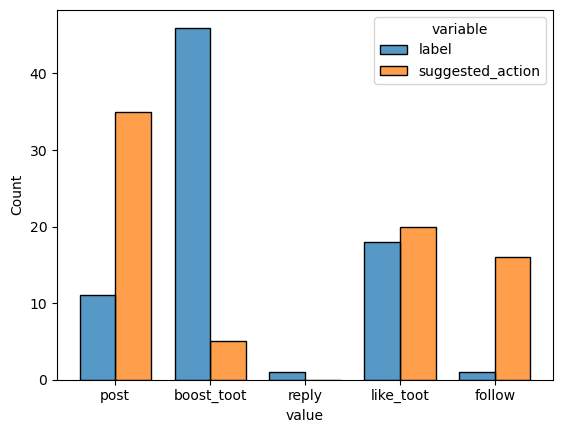

In [14]:
import seaborn as sns
import matplotlib.pyplot as pl

action_probabilities = {
    "like_toot": 0.05,  # 20,  # Most common action
    "boost_toot": 0.05,  # 0.15,  # Common but less than likes
    "post": 0.7,  # 0.35,  # Regular posting
    "reply": 0.1,  # 0.20,
    # Medium frequency actions
    "follow": 0.05,  # Following new accounts
    "unfollow": 0.00,  # Unfollowing accounts
    "print_timeline": 0.04,  # Reading timeline
    # Low frequency actions
    "block_user": 0.0,  # Blocking problematic users
    "unblock_user": 0.0,  # Unblocking users
    "delete_posts": 0.0,  # Deleting own posts
    "update_bio": 0.0,  # Updating profile
    "print_notifications": 0.01,  # Checking notifications
}
action_probabilities = {
    # High frequency actions
    "like_toot": 0.35,  # Most common action
    "boost_toot": 0.15,  # Common but less than likes
    "toot": 0.20,  # Regular posting
    "reply": 0.15,
    # Medium frequency actions
    "follow": 0.15,  # Following new accounts
    "unfollow": 0.00,  # 25,  # Unfollowing accounts
    "print_timeline": 0.0,  # Reading timeline
    # Low frequency actions
    "block_user": 0.0,  # Blocking problematic users
    "unblock_user": 0.0,  # Unblocking users
    "delete_posts": 0.0,  # Deleting own posts
    "update_bio": 0.0,  # Updating profile
    "print_notifications": 0.00,  # 25,  # Checking notifications
}
fig, ax = pl.subplots()
dft = df.loc[(df.event_type == "action") & (df.episode > -1), :].copy()
dft["suggested_action"] = dft["data"].apply(
    lambda x: "post" if x["suggested_action"] == "toot" else x["suggested_action"]
)
sns.histplot(
    data=dft.loc[:, ["label", "suggested_action"]].melt(),
    ax=ax,
    x="value",
    hue="variable",
    multiple="dodge",
    shrink=0.75,
    bins=20,
)
action_list = [obj.get_text() for obj in ax.get_xticklabels()]
ax.plot(
    range(len(action_list)),
    [action_probabilities[action] * len(dft) for action in action_list],
    ".-",
)
ax.set_title("line is expected count from suggested freqs")

In [68]:
action_dict = dict(
    zip([x.get_text() for x in ax.get_xticklabels()], range(len(ax.get_xticklabels())))
)
action_dict

{'post': 0, 'reply': 1, 'boost_toot': 2, 'follow': 3, 'print_timeline': 4}

In [64]:
actions_in_data

['follow', 'post', 'reply', 'print_timeline', 'boost_toot']

In [24]:
df.loc[df.source_user == "Michael Harris", :]
df.loc[df.source_user.apply(lambda x: x.split(" ")[0]) == "Jessica", :]

,source_user,label,data,episode,event_type
11,Jessica Rodriguez,follow,"{'target_user': 'Bill Fredrickson', 'suggested...",-1,action
15,Jessica Thompson,follow,"{'target_user': 'Bill Fredrickson', 'suggested...",-1,action
17,Jessica Rodriguez,follow,"{'target_user': 'Bradley Carter', 'suggested_a...",-1,action
18,Jessica Thompson,follow,"{'target_user': 'Bradley Carter', 'suggested_a...",-1,action
19,Jessica Thompson,follow,"{'target_user': 'Bill Fredrickson', 'suggested...",-1,action
21,Jessica Thompson,follow,"{'target_user': 'Sam Jenkins', 'suggested_acti...",-1,action
23,Jessica Thompson,follow,"{'target_user': 'Lisa Collins', 'suggested_act...",-1,action
24,Jessica Thompson,follow,"{'target_user': 'Chris Anderson', 'suggested_a...",-1,action
25,Jessica Thompson,follow,"{'target_user': 'Alex Thompson', 'suggested_ac...",-1,action
76,Jessica Rodriguez,follow,"{'target_user': 'Rahul Desai', 'suggested_acti...",-1,action


In [19]:
# df.loc[(df.label=='post') & (df.episode>-1)]['data'].apply(lambda x:x['post_text'])
df.loc[(df.label == "post") & (df.episode > -1)]["episode"]

341      0
514      2
684      4
860      6
3268    34
3441    36
3613    38
3790    40
3965    42
4133    44
4306    46
Name: episode, dtype: int64

In [41]:
(datetime.date.today() + datetime.timedelta(minutes=90)).strftime("%H:%M %p")

'00:00 AM'

In [47]:
today = datetime.now()
today.hour = 8
today

AttributeError: module 'datetime' has no attribute 'now'

In [54]:
import datetime

today = datetime.date.today()
start_date = datetime.datetime(year=today.year, month=today.month, day=today.day, hour=8, minute=0)
for td in (start_date + datetime.timedelta(minutes=30 * it) for it in range(num_posts)):
    print(td.strftime("%H:%M %p"))

08:00 AM
08:30 AM
09:00 AM
09:30 AM
10:00 AM
10:30 AM
11:00 AM
11:30 AM
12:00 PM
12:30 PM
13:00 PM
13:30 PM
14:00 PM
14:30 PM
15:00 PM
15:30 PM
16:00 PM
16:30 PM
17:00 PM
17:30 PM
18:00 PM
18:30 PM
19:00 PM
19:30 PM
20:00 PM
20:30 PM
21:00 PM
21:30 PM
22:00 PM
22:30 PM
23:00 PM
23:30 PM
00:00 AM
00:30 AM
01:00 AM
01:30 AM
02:00 AM
02:30 AM
03:00 AM
03:30 AM
04:00 AM
04:30 AM
05:00 AM
05:30 AM
06:00 AM
06:30 AM
07:00 AM
07:30 AM


In [48]:
num_posts = 48
total_hours = int(num_posts / 2)
starting_hour = 8
datetime
[
    "%s:%s " % (h, m)
    for h in list(range(starting_hour, starting_hour + total_hours))
    for m in ("00", "30")
]

['8:00 ',
 '8:30 ',
 '9:00 ',
 '9:30 ',
 '10:00 ',
 '10:30 ',
 '11:00 ',
 '11:30 ',
 '12:00 ',
 '12:30 ',
 '13:00 ',
 '13:30 ',
 '14:00 ',
 '14:30 ',
 '15:00 ',
 '15:30 ',
 '16:00 ',
 '16:30 ',
 '17:00 ',
 '17:30 ',
 '18:00 ',
 '18:30 ',
 '19:00 ',
 '19:30 ',
 '20:00 ',
 '20:30 ',
 '21:00 ',
 '21:30 ',
 '22:00 ',
 '22:30 ',
 '23:00 ',
 '23:30 ',
 '24:00 ',
 '24:30 ',
 '25:00 ',
 '25:30 ',
 '26:00 ',
 '26:30 ',
 '27:00 ',
 '27:30 ',
 '28:00 ',
 '28:30 ',
 '29:00 ',
 '29:30 ',
 '30:00 ',
 '30:30 ',
 '31:00 ',
 '31:30 ']

In [6]:
fileroot = "../output/N20_T_40_None_Big5_independent"
fileroot = "examples/election/output/N20_None_Big5_malicious"

df = load_data(fileroot)
print()

eval_df, int_df, edge_df = post_process_output(df)
print(int_df)
print()
print(eval_df)
print()
print(edge_df)
print()

follow_graph, int_dict, posted_users_by_episode, toot_dict, votes = load_data_dash(
    eval_df, int_df, edge_df
)
print()
print("follow_graph")
print(follow_graph)
print()
print("int_dict")
print(int_dict)
print()
print("poster_users_by_episode")
print(posted_users_by_episode)
print()
print("toot_dict")
print(toot_dict)
print()
print("votes")
print(votes)

        source_user   label                                 data  episode event_type
0  Bill Fredrickson  follow    {'target_user': 'Jessica Nguyen'}       -1     action
1  Bill Fredrickson  follow     {'target_user': 'Liam Schwartz'}       -1     action
2  Bill Fredrickson  follow    {'target_user': 'Robert Johnson'}       -1     action
3    Bradley Carter  follow  {'target_user': 'Bill Fredrickson'}       -1     action
4  Bill Fredrickson  follow      {'target_user': 'Sophia Patel'}       -1     action

Evals:
label
favorability    1920
vote_pref        960
vote_intent      960
Name: count, dtype: int64

Actions:
label
follow        224
boost_toot    197
like_toot      74
reply          58
post           33
Name: count, dtype: int64

data
(toot_id, target_user)            271
(target_user)                     224
(reply_to, toot_id, post_text)     58
(toot_id, post_text)               33
Name: count, dtype: int64

        source_user       label                                       

In [7]:
[
    sum(1 for value in epi_votes.values() if value == "Invalid Answer") / 20.0
    for epi_votes in votes.values()
]

[0.65,
 0.65,
 0.25,
 0.25,
 0.25,
 0.15,
 0.15,
 0.25,
 0.35,
 0.25,
 0.05,
 0.2,
 0.15,
 0.1,
 0.2,
 0.2,
 0.1,
 0.05,
 0.1,
 0.05,
 0.2,
 0.1,
 0.2,
 0.1,
 0.2,
 0.15,
 0.25,
 0.2,
 0.45,
 0.15,
 0.2,
 0.15,
 0.3,
 0.25,
 0.2,
 0.15,
 0.25,
 0.45,
 0.2,
 0.2,
 0.3,
 0.05,
 0.2,
 0.1,
 0.1,
 0.25,
 0.1,
 0.1]

In [9]:
def get_int_dict(int_df):
    past = dict(
        zip(
            ["post", "like_toot", "boost_toot", "reply"],
            ["posted", "liked", "boosted", "replied"],
            strict=False,
        )
    )
    int_df["int_data"] = int_df.apply(
        lambda x: {
            "action": past[x.label],
            "episode": x.episode,
            "source": x.source_user,
            "target": get_target_user(x),
            "toot_id": x.data["toot_id"],
        },
        axis=1,
    )
    int_df.int_data = int_df.apply(
        lambda x: x.int_data | {"parent_toot_id": x.data["reply_to"]["toot_id"]}
        if x.label == "reply"
        else x.int_data,
        axis=1,
    )
    return int_df.groupby("episode")["int_data"].apply(list).to_dict()

In [10]:
int_dict = get_int_dict(int_df)
int_dict

{-1: [{'action': 'posted',
   'episode': -1,
   'source': 'Jessica Nguyen',
   'target': 'Jessica Nguyen',
   'toot_id': 113674293624587527},
  {'action': 'posted',
   'episode': -1,
   'source': 'Janet Thompson',
   'target': 'Janet Thompson',
   'toot_id': 113674293632133311},
  {'action': 'posted',
   'episode': -1,
   'source': 'Liam Schwartz',
   'target': 'Liam Schwartz',
   'toot_id': 113674293673813891},
  {'action': 'posted',
   'episode': -1,
   'source': 'Emily Jacobs',
   'target': 'Emily Jacobs',
   'toot_id': 113674293679164293},
  {'action': 'posted',
   'episode': -1,
   'source': 'Maggie Chen',
   'target': 'Maggie Chen',
   'toot_id': 113674293692327582},
  {'action': 'posted',
   'episode': -1,
   'source': 'Roger Davis',
   'target': 'Roger Davis',
   'toot_id': 113674293714759598},
  {'action': 'posted',
   'episode': -1,
   'source': 'Mark Rodriguez',
   'target': 'Mark Rodriguez',
   'toot_id': 113674293720557675},
  {'action': 'posted',
   'episode': -1,
   'sou